In [1]:
import matplotlib.pyplot as plt
import torch
from loader import *
from models.fast import FAST
from models.loss.balanced_bce_loss import BalancedBCELoss
from models.loss.dice_loss import DiceLoss
from train import calculate_total_loss
from models.utils import evaluate, evaluate_micro

%load_ext autoreload
%autoreload 2

/home/zachhendon/miniconda3/envs/text-detection/lib/python3.12/site-packages/kornia/feature/lightglue.py:44: FutureWarning: `torch.cuda.amp.custom_fwd(args...)` is deprecated. Please use `torch.amp.custom_fwd(args..., device_type='cuda')` instead.
  @torch.cuda.amp.custom_fwd(cast_inputs=torch.float32)


In [5]:
model = FAST().cuda()
checkpoint = torch.load("checkpoints/fast_synthtext_007/40000.pth", weights_only=True)
model.load_state_dict(checkpoint["model_state_dict"])
print(f"Iteration: {checkpoint["iteration"]}")

train_loader, val_loader = get_synthtext_loaders(batch_size=2)

Iteration: 40000


Kernel Loss: 0.14711816608905792
Text Loss: 0.0808948278427124
Total Loss: 0.18756558001041412


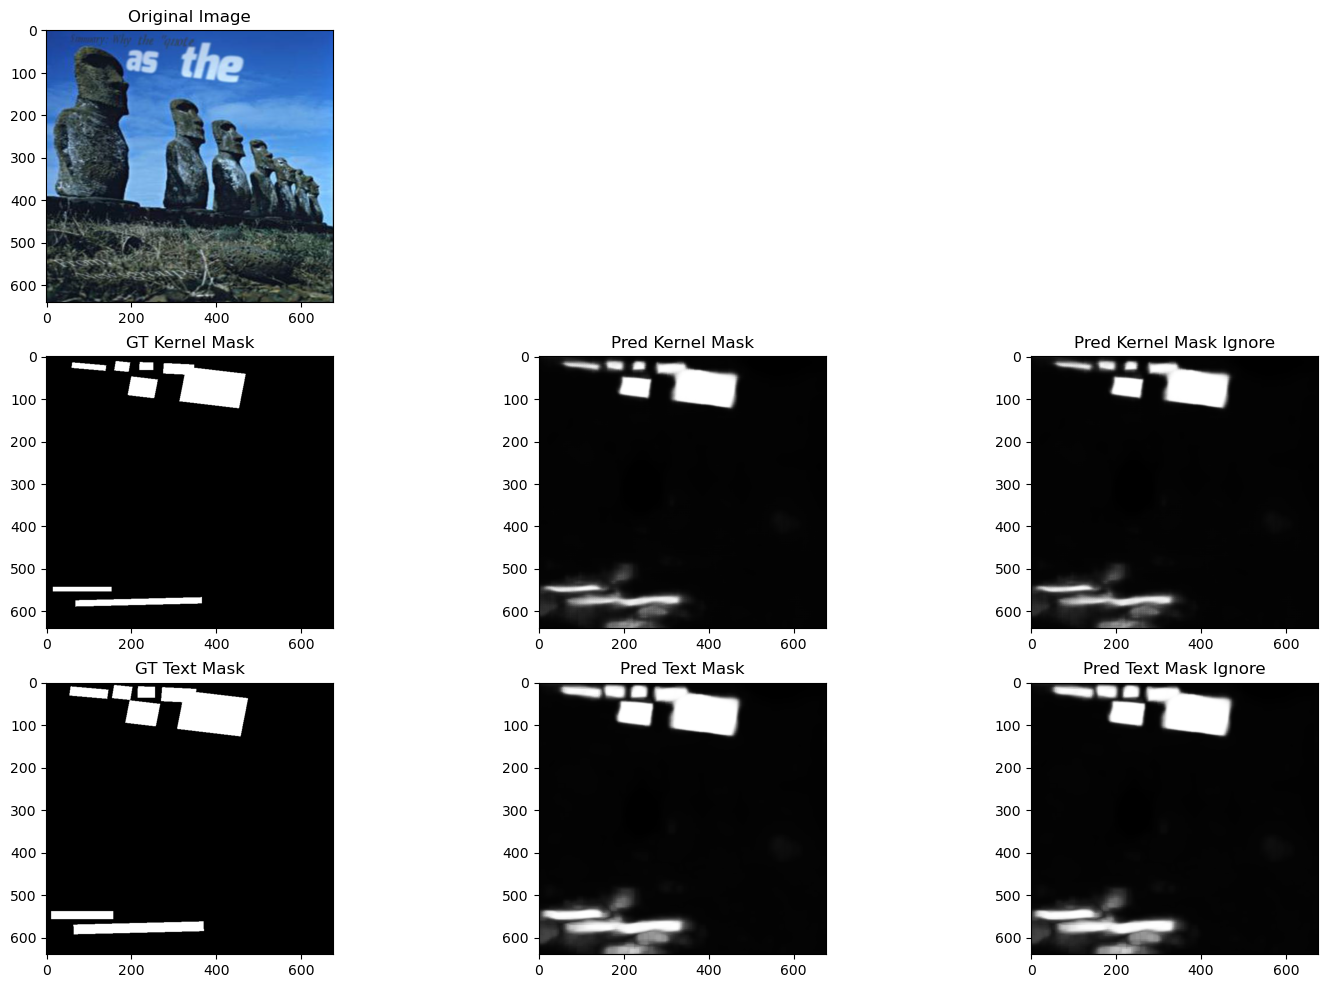

In [6]:
# images, kernel_masks, ignore_kernel_masks, text_masks, ignore_text_masks = next(
#     train_loader
# )
images, kernel_masks, ignore_kernel_masks, text_masks, ignore_text_masks, _, _ = next(
    val_loader
)
preds = model(images)
dilated_preds = torch.nn.functional.max_pool2d(
    preds, kernel_size=9, stride=1, padding=4
)

fig, axs = plt.subplots(3, 3, figsize=(18, 12))
fig.delaxes(axs[0][1])
fig.delaxes(axs[0][2])

# original image
image = (images[0] - images[0].min()) / (images[0].max() - images[0].min())
axs[0][0].imshow(image.permute(1, 2, 0).cpu().numpy())
axs[0][0].set_title("Original Image")

# gt kernel mask
axs[1][0].imshow(kernel_masks[0].cpu().numpy(),vmin=0, vmax=1, cmap='gray')
axs[1][0].set_title("GT Kernel Mask")
# pred kernel mask
axs[1][1].imshow(preds[0].cpu().detach().numpy(),vmin=0, vmax=1, cmap='gray')
axs[1][1].set_title("Pred Kernel Mask")
# pred kernel mask ignore
axs[1][2].imshow((preds * ignore_kernel_masks)[0].cpu().detach().numpy(),vmin=0, vmax=1, cmap='gray')
axs[1][2].set_title("Pred Kernel Mask Ignore")

# gt text mask
axs[2][0].imshow(text_masks[0].cpu().numpy(),vmin=0, vmax=1, cmap='gray')
axs[2][0].set_title("GT Text Mask")
# pred text mask
axs[2][1].imshow(dilated_preds[0].cpu().detach().numpy(),vmin=0, vmax=1, cmap='gray')
axs[2][1].set_title("Pred Text Mask")
# pred text mask ignore
axs[2][2].imshow((dilated_preds * ignore_text_masks)[0].cpu().detach().numpy(),vmin=0, vmax=1, cmap='gray')
axs[2][2].set_title("Pred Text Mask Ignore")

kernel_loss = BalancedBCELoss()(preds, kernel_masks, ignore_kernel_masks)
text_loss = DiceLoss()(dilated_preds, text_masks, ignore_text_masks)
total_loss = calculate_total_loss(kernel_loss, text_loss)
print(f"Kernel Loss: {kernel_loss.item()}")
print(f"Text Loss: {text_loss.item()}")
print(f"Total Loss: {total_loss.item()}")

plt.show()

## Evaluate

In [270]:
train_loader, val_loader = get_synthtext_loaders(batch_size=16)
evaluate(model, val_loader, iter_limit=50)

(0.8746126396500816, 0.788796344197374, 0.8294908341171574)

In [271]:
train_loader, val_loader = get_synthtext_loaders(batch_size=16)
evaluate_micro(model, val_loader, iter_limit=50)

(0.8800770589179644, 0.793342981186686, 0.834462287845346)